# Custom Dataset for Garbage Classification

In this notebook, we will create a custom dataset for garbage classification using images from 12 classes. We will manually read the images, assign labels, and use a PyTorch DataLoader for training.

## Step 1: Check Input Data

First, let's check what we have in the input data directory.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/garbage-classification/garbage_classification/metal/metal375.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal561.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal341.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal688.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal374.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal427.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal383.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal692.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal560.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal702.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal215.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal113.jpg
/kaggle/input/garbage-classification/garbage_classif

In [10]:
# Import necessary libraries
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        """
        Initialize the dataset with the directory containing images, class names, and transformations.

        Parameters:
        root_dir (str): Directory with all the images.
        classes (list): List of class names.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.image_paths, self.labels = self._load_images_and_labels()

    def _load_images_and_labels(self):
        """
        Load images and their corresponding labels from the directory.

        Returns:
        image_paths (list): List of image file paths.
        labels (list): List of labels corresponding to the images.
        """
        image_paths = []
        labels = []
        for label, classname in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, classname)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(label)
        return image_paths, labels

    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset at the given index.

        Parameters:
        idx (int): Index of the sample.

        Returns:
        image (Tensor): Transformed image.
        label (int): Label of the image.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [7]:
# Define the classes
classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
           'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# Define the root directory where images are stored
root_dir = '/kaggle/input/garbage-classification/garbage_classification/'

# Create the custom dataset
custom_dataset = CustomImageDataset(root_dir=root_dir, classes=classes, transform=transform)

# Split the dataset into training (80%) and test (20%) sets
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

In [24]:
# Create data loaders
train_batch_size = 32
test_batch_size = 4

trainloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

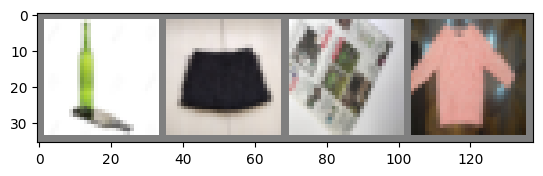

green-glass clothes paper clothes


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(test_batch_size)))

2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [17]:
num_class = len(classes)

In [20]:
import torch.nn as nn
import torch.nn.functional as F


# Define the neural network by inheriting from nn.Module
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the first convolutional layer
        # - in_channels: Number of input channels (3 for RGB images)
        # - out_channels: Number of output channels (6 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Define a max-pooling layer
        # - kernel_size: Size of the pooling window (2x2)
        # - stride: Step size for the window (2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the second convolutional layer
        # - in_channels: Number of input channels (6 from previous conv layer)
        # - out_channels: Number of output channels (16 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Define the first fully connected layer
        # - in_features: Number of input features (16 * 5 * 5 from previous layers)
        # - out_features: Number of output features (120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # Define the second fully connected layer
        # - in_features: Number of input features (120)
        # - out_features: Number of output features (84)
        self.fc2 = nn.Linear(120, 84)
        
        # Define the third fully connected layer
        # - in_features: Number of input features (84)
        # - out_features: Number of output features (10, for 10 classes)
        # self.fc3 = nn.Linear(84, 10)
        self.fc3 = nn.Linear(84, num_class)

    # Define the forward pass
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Apply the second convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor, keeping the batch dimension
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        # Apply the third fully connected layer to produce the final output
        x = self.fc3(x)
        
        return x

# Create an instance of the neural network and move it to the specified device (CPU or GPU)
net = Net().to(device)

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=12, bias=True)
)


3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [30]:
print("Start Training:")
# Train the network for a specified number of epochs (here, 2 epochs)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0  # Initialize the running loss for each epoch
    for i, data in enumerate(trainloader, 0):
        # Get the inputs and labels from the data loader
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Move the inputs and labels to the specified device (CPU or GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients to avoid accumulation from previous iterations
        optimizer.zero_grad()

        # Perform the forward pass: compute the network's outputs
        outputs = net(inputs)
        
        # Compute the loss using the criterion
        loss = criterion(outputs, labels)
        
        # Perform the backward pass: compute the gradients
        loss.backward()
        
        # Update the network parameters using the optimizer
        optimizer.step()

        # Accumulate the loss for the current mini-batch
        running_loss += loss.item()
        
        # Print statistics every 100 mini-batches
        if i % 100 == 0:
            print(f'[{epoch + 1}, {i:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0  # Reset the running loss for the next set of mini-batches

print('Finished Training')

Start Training:
[1,     1] loss: 0.001
[1,   101] loss: 0.088
[1,   201] loss: 0.085
[1,   301] loss: 0.084
[2,     1] loss: 0.001
[2,   101] loss: 0.080
[2,   201] loss: 0.082
[2,   301] loss: 0.080
Finished Training


Let\'s quickly save our trained model:


In [31]:
PATH = './custom_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


# We wont use GPU for testing, as we dont have to do update the model.

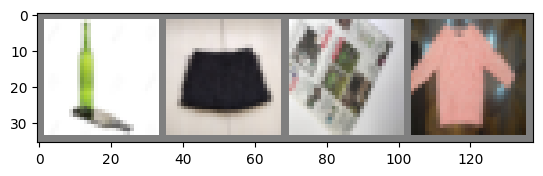

GroundTruth:  green-glass clothes paper clothes


In [32]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [33]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [34]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  trash clothes shoes clothes


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 47 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [38]:
# Prepare dictionaries to count correct and total predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        # Get the inputs and labels from the data loader
        images, labels = data
        
        # Move the inputs to the specified device (CPU or GPU)
        images = images
        
        # Perform the forward pass: compute the network's outputs
        outputs = net(images)
        
        # Get the predicted class with the highest score
        _, predictions = torch.max(outputs, 1)
        
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: battery is 32.0 %
Accuracy for class: biological is 0.0 %
Accuracy for class: brown-glass is 8.3 %
Accuracy for class: cardboard is 20.0 %
Accuracy for class: clothes is 95.0 %
Accuracy for class: green-glass is 34.9 %
Accuracy for class: metal is 1.4 %
Accuracy for class: paper is 35.3 %
Accuracy for class: plastic is 2.7 %
Accuracy for class: shoes is 38.7 %
Accuracy for class: trash is 79.0 %
Accuracy for class: white-glass is 2.6 %
